# CPSC 340 Lecture 29 demo

UBC CPSC 340, Mike Gelbart

Dependencies:
   Autograd: `pip install autograd`
   Keras (optional): `pip install keras`
   Tensorflow (optional): `pip install tensorflow`

In [3]:
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

## Neural network example in Autograd

A simple neural net implementation with gradient descent (not even SGD), for regression. Implemented with Autograd to avoid taking the derivative.

Attribution: adapted from [neural network example](https://github.com/HIPS/autograd/blob/master/examples/neural_net.py) on the Autograd website.

In [4]:
class NeuralNet():
    def __init__(self, layer_sizes, learning_rate=0.1, num_epochs=100, init_W_sd=1, activation="tanh"):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.num_layers = len(layer_sizes)-1
        self.activation = activation
        
        self.W = list()
        for l in range(len(layer_sizes)-1):
            size_in = layer_sizes[l]
            size_out= layer_sizes[l+1]
            self.W.append(init_W_sd/np.sqrt(size_in)*npr.randn(size_in+1, size_out))
        self.W = tuple(self.W) # autograd wants it to be a tuple rather than a list

    def fit(self, X, y):
        objective = lambda W: np.mean((y - self.predict(X, W))**2)
        objective_grad = grad(objective)
        objective_grad(self.W)
        err = list()
        for i in range(self.num_epochs):
            W_grad = objective_grad(self.W)
            for l in range(self.num_layers):
                W_l = self.W[l]
                W_l -= self.learning_rate * W_grad[l]
            err.append(objective(self.W))
        return err # return plot of error versus epochs FYI
        
    def predict(self, X, W=None):
        if W is None:
            W = self.W
        inputs = X
        
        for W_l in W:
            outputs = inputs @ W_l[:-1,:] + W_l[-1]
            inputs = np.tanh(outputs) if self.activation=="tanh" else np.maximum(0, outputs) # ReLU
        return outputs


Training error: 0.000996


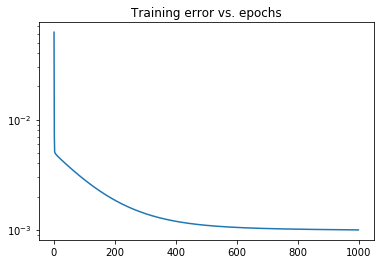

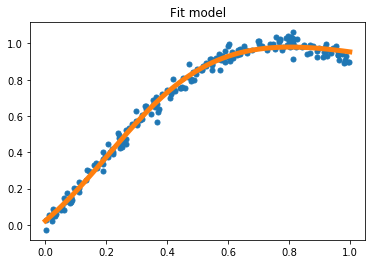

In [5]:
# generate fake data
npr.seed(5)
N = 200
X = npr.rand(N,1)
y = np.sin(2*X) + npr.randn(N,1)*0.03
layer_sizes = [1,10, 1]

NN = NeuralNet(layer_sizes,num_epochs=1000,learning_rate=0.1,init_W_sd=1)
err = NN.fit(X,y)
plt.semilogy(err)
plt.title("Training error vs. epochs")
#NN.predict(X)

plt.figure()
plt.plot(X,y,'.',markersize=10)
grid = np.linspace(0,1,1000)[:,None]
plt.plot(grid, NN.predict(grid),linewidth=5)
plt.title("Fit model")
# list(map(lambda x: x.shape, NN.W))

y_pred = NN.predict(X)
print("Training error: %f" % np.mean((y_pred-y)**2))

## Random weights

To build intuition about the types of functions we can represent, let's explore what happens with random weights using different architectures. Again, this is all within the confines of $\mathbb{R}\rightarrow\mathbb{R}$ which isn't the real deal.


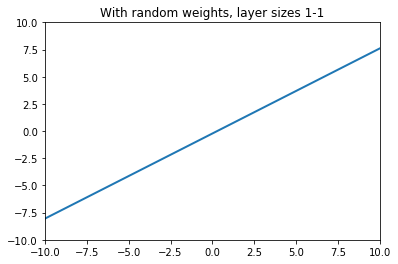

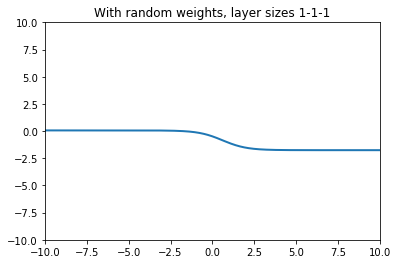

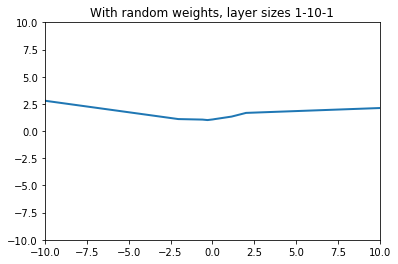

In [27]:
def plot_random_weights_1D(layer_sizes, activation="tanh"):
    NN = NeuralNet(layer_sizes,init_W_sd=1,activation=activation)

    plt.figure()
    grid = np.linspace(-10,10,1000)[:,None]
    plt.plot(grid, NN.predict(grid),linewidth=2)
    plt.title("With random weights, layer sizes %s" % "-".join(map(str,layer_sizes)))
    plt.xlim([-10,10])
    plt.ylim([-10,10])
    plt.show()
    
plot_random_weights_1D((1,1)) # this is just linear regression

plot_random_weights_1D((1,1,1)) # this does something fancier

plot_random_weights_1D((1,10,1),activation="relu") # this gives us piecewise linear functions

Regression example with $D=2$

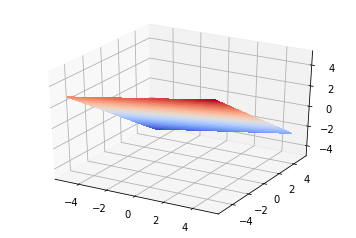

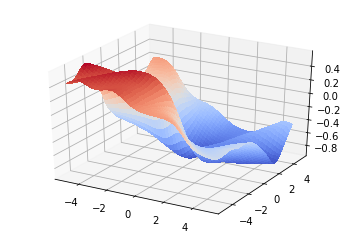

In [31]:
def plot_random_weights_2D(layer_sizes, activation="tanh"):

    NN = NeuralNet(layer_sizes,init_W_sd=1,activation=activation)
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    n = 100
    X = np.linspace(-5, 5, n)
    Y = np.linspace(-5, 5, n)
    X, Y = np.meshgrid(X, Y)

    inputs = np.append(X.flatten()[:,None], Y.flatten()[:,None],axis=1)
    outputs = NN.predict(inputs)
    Z = np.reshape(outputs, [n,n])

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    plt.show()
    
plot_random_weights_2D((2,1))
plot_random_weights_2D((2,50,1))


## Deep learning software

There's been a lot of software released lately to take care of this for you. Some big players are:

| Name   |  Host language  | Released |  Comments | 
|--------|-------------|---------------|----------|
| [Theano](http://deeplearning.net/software/theano/) | Python | 2007 | From U. de Montréal |
| [Torch](http://torch.ch) | Lua | 2002 | Used at Facebook |
| [PyTorch](http://pytorch.org) | Python | 2017 | Automatic differentiation through arbitrary code like Autograd
| [TensorFlow](https://www.tensorflow.org) | Python | 2015 | Created by Google for both prototyping and production
| [Keras](https://keras.io) | Python | 2015 | A front-end on top of Theano or TensorFlow |
| [Caffe](http://caffe.berkeleyvision.org) | Executable with Python wrapper | 2014 | Specifically for convolution neural nets (see Lecture 31), by UC Berkeley

- There are many others of course. See for example [Comparison of deep learning software](https://en.wikipedia.org/wiki/Comparison_of_deep_learning_software).
- From the table above, we can see there have been a lot of new packages released recently.

## Repeating the examples above in Keras

For the following to work, you need to have Keras installed. Sometimes it's as easy as `pip install keras` and `pip install tensorflow` but I've seen it fail too...

In [33]:
from keras.models import Sequential
from keras.layers import Dense
import keras

Using TensorFlow backend.


In [47]:
# generate fake data
npr.seed(5)
N = 200
X = npr.rand(N,1)
y = np.sin(2*X) + npr.randn(N,1)*0.03

Training a 1-D regression model:

In [52]:
model = Sequential()
model.add(Dense(10, input_dim=1, init='lecun_uniform', activation='tanh'))
model.add(Dense(1, init='lecun_uniform', activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, y, nb_epoch=500, verbose=0)

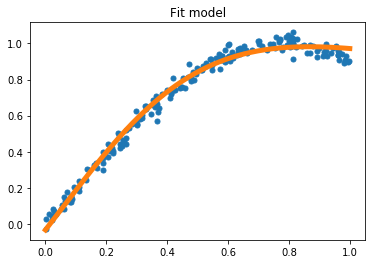

In [53]:
plt.figure()
plt.plot(X,y,'.',markersize=10)
grid = np.linspace(0,1,1000)[:,None]
plt.plot(grid, model.predict(grid),linewidth=5)
plt.title("Fit model")

Random weights:

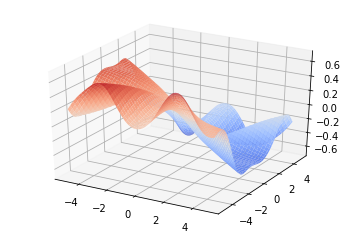

In [43]:
model = Sequential()
model.add(Dense(50, input_dim=2, init='lecun_uniform', activation='tanh'))
model.add(Dense(1, init='lecun_uniform', activation='linear'))
model.compile(loss='mean_squared_error', optimizer='sgd')

fig = plt.figure()
ax = fig.gca(projection='3d')

n = 100
X = np.linspace(-5, 5, n)
Y = np.linspace(-5, 5, n)
X, Y = np.meshgrid(X, Y)

inputs = np.append(X.flatten()[:,None], Y.flatten()[:,None],axis=1)
outputs = model.predict(inputs)
Z = np.reshape(outputs, [n,n])

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0)
